Imports

In [1]:
import numpy as np
from pandas import read_excel, concat, DataFrame, Index, MultiIndex, date_range
from numpy import empty, full
import matplotlib.pyplot as plt
from pathlib import Path


from pandas import read_excel, concat, DataFrame, Index, MultiIndex, date_range
from numpy import empty, full
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

Load the file

In [2]:
def load(file_name, sheet):
    return read_excel(file_name, sheet_name=sheet)

In [3]:
def load_file(file_name):

    #### Loading the information
    st = load(file_name, 'sites')
    wx = load(file_name, 'weather')
    idx = load(file_name, 'index')

    return st, wx, idx

def load_filegs(file_name):

    #### Loading the information
    st = load(file_name, 'sites')
    idx = load(file_name, 'index')
    gs = load(file_name, 'growth stage')

    return st, idx, gs


Build the plots here:

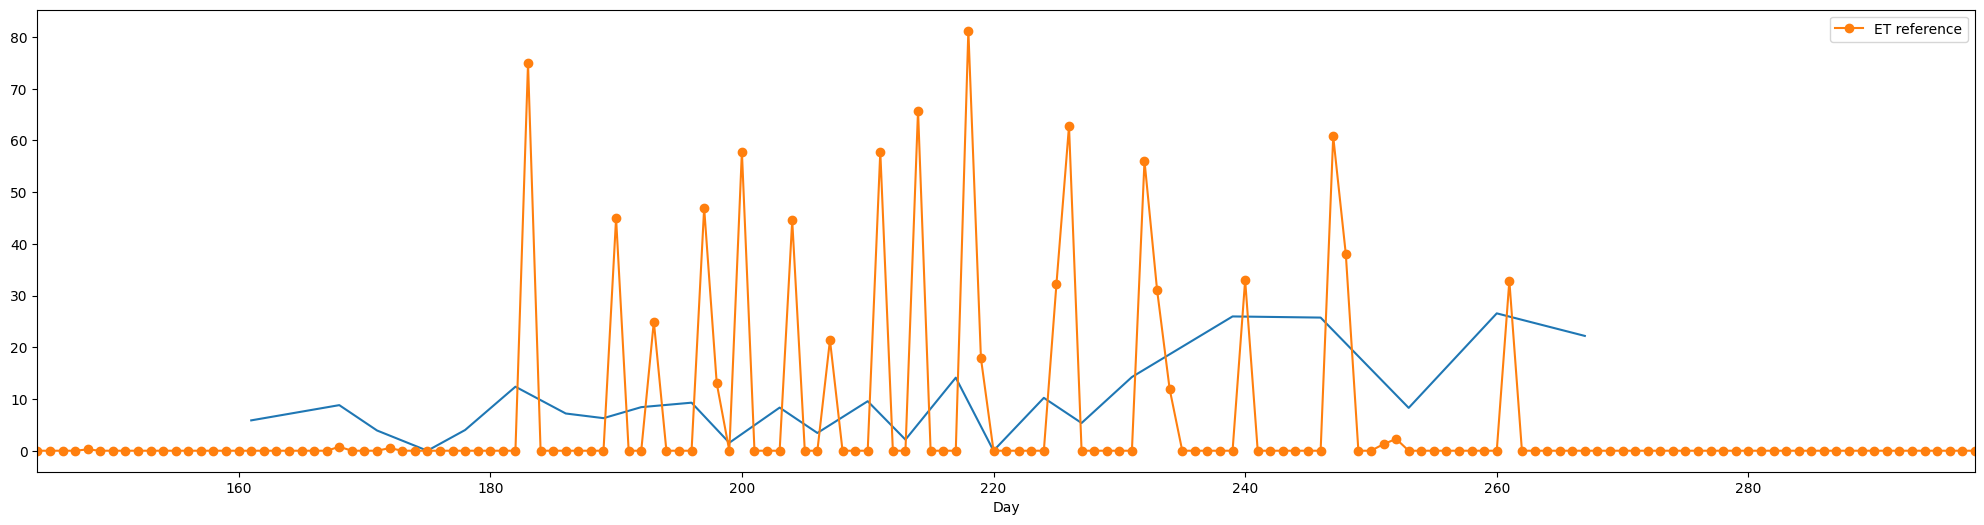

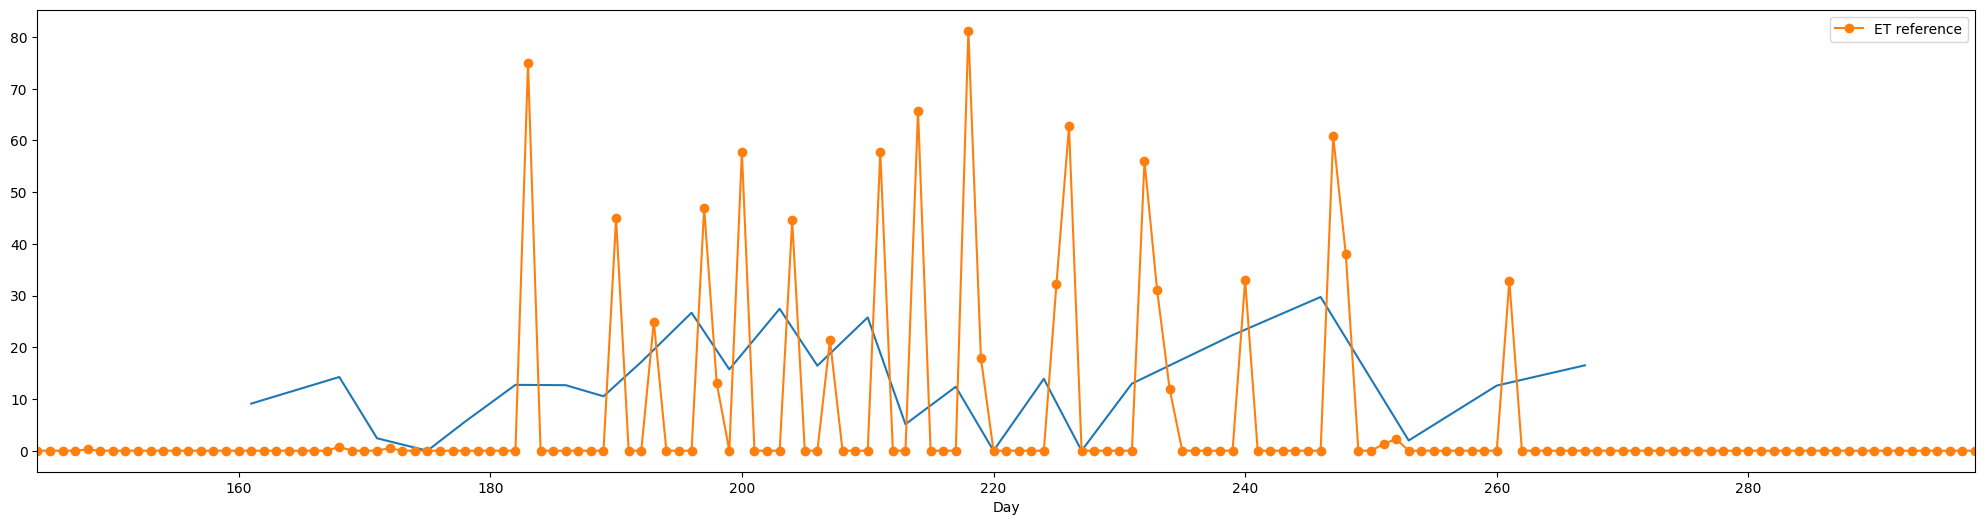

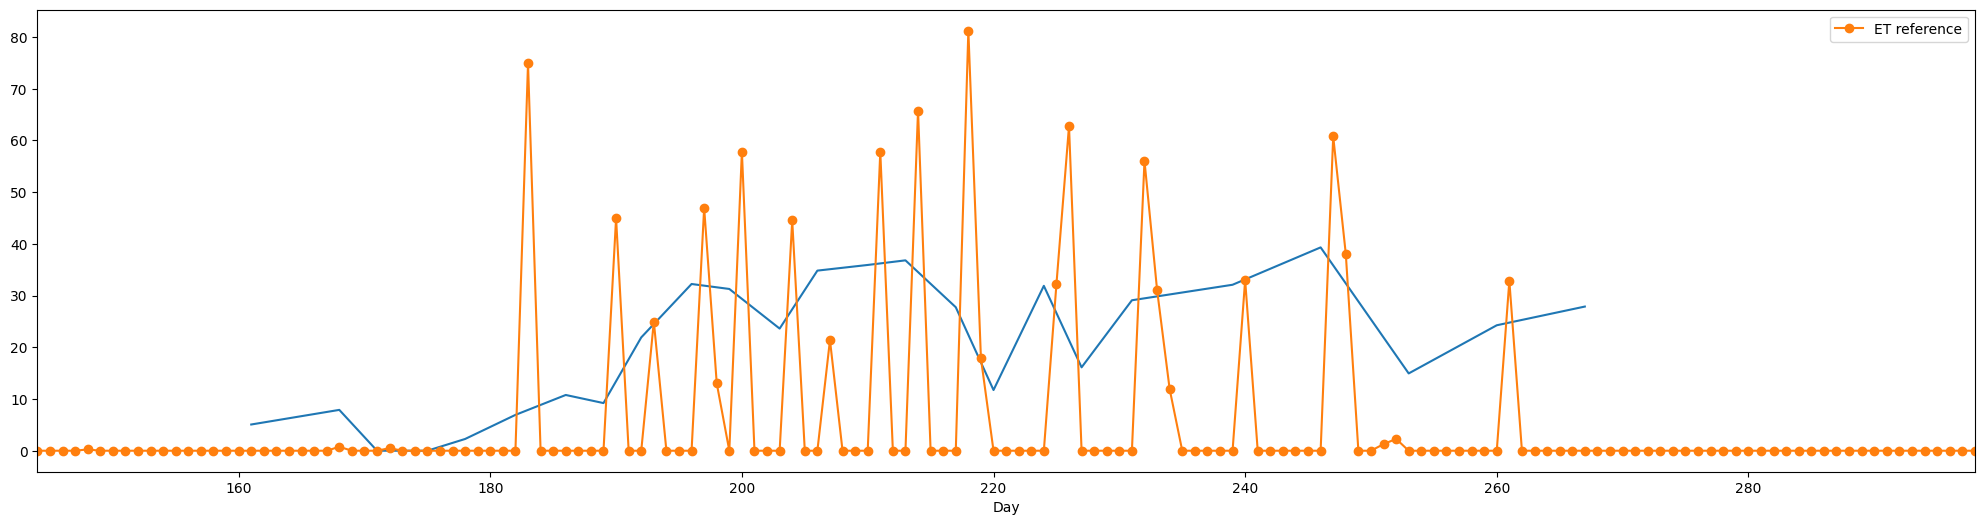

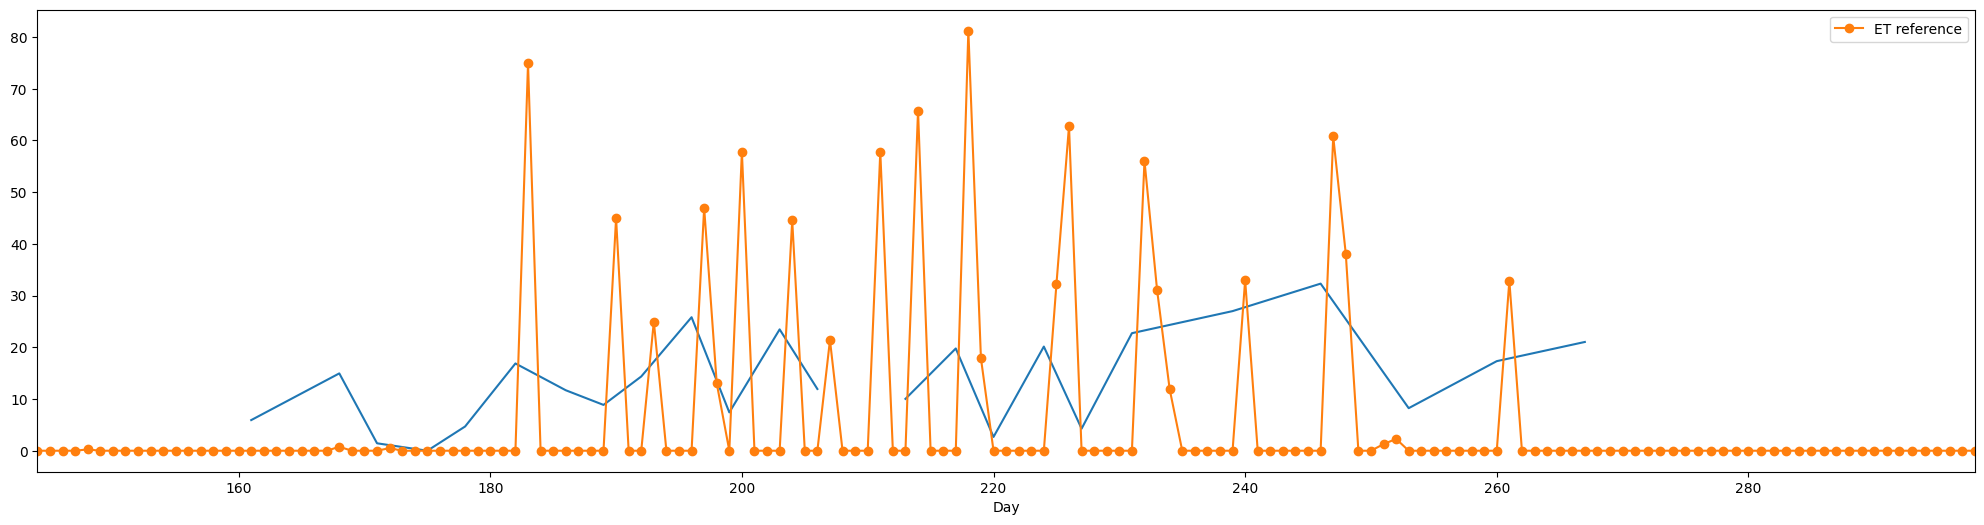

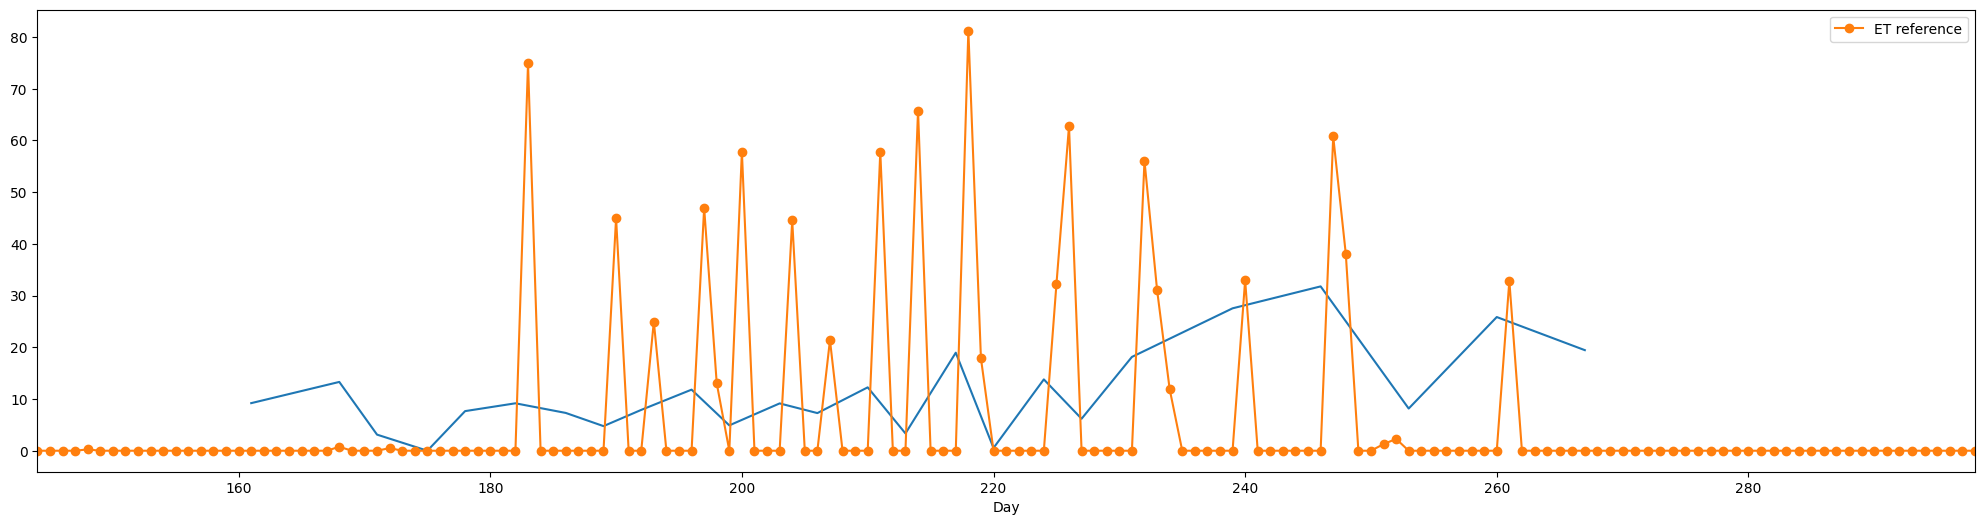

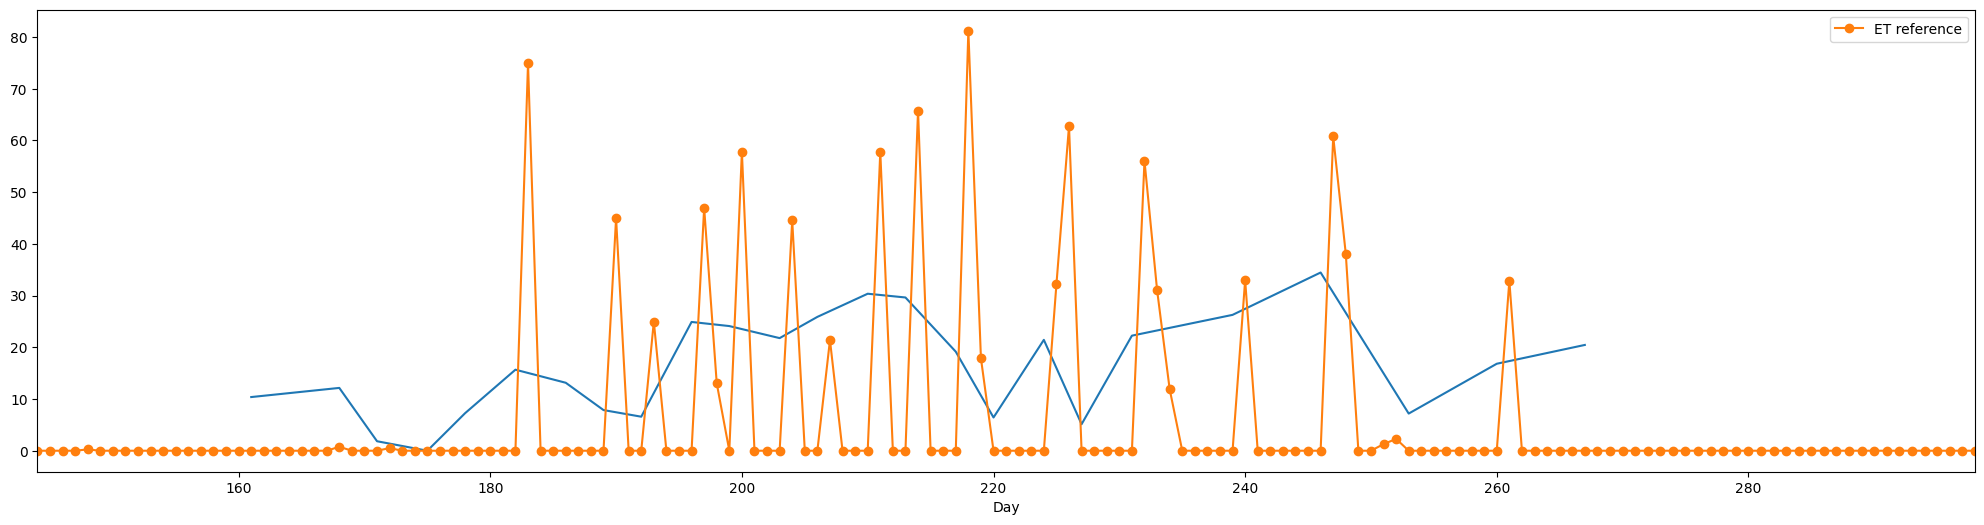

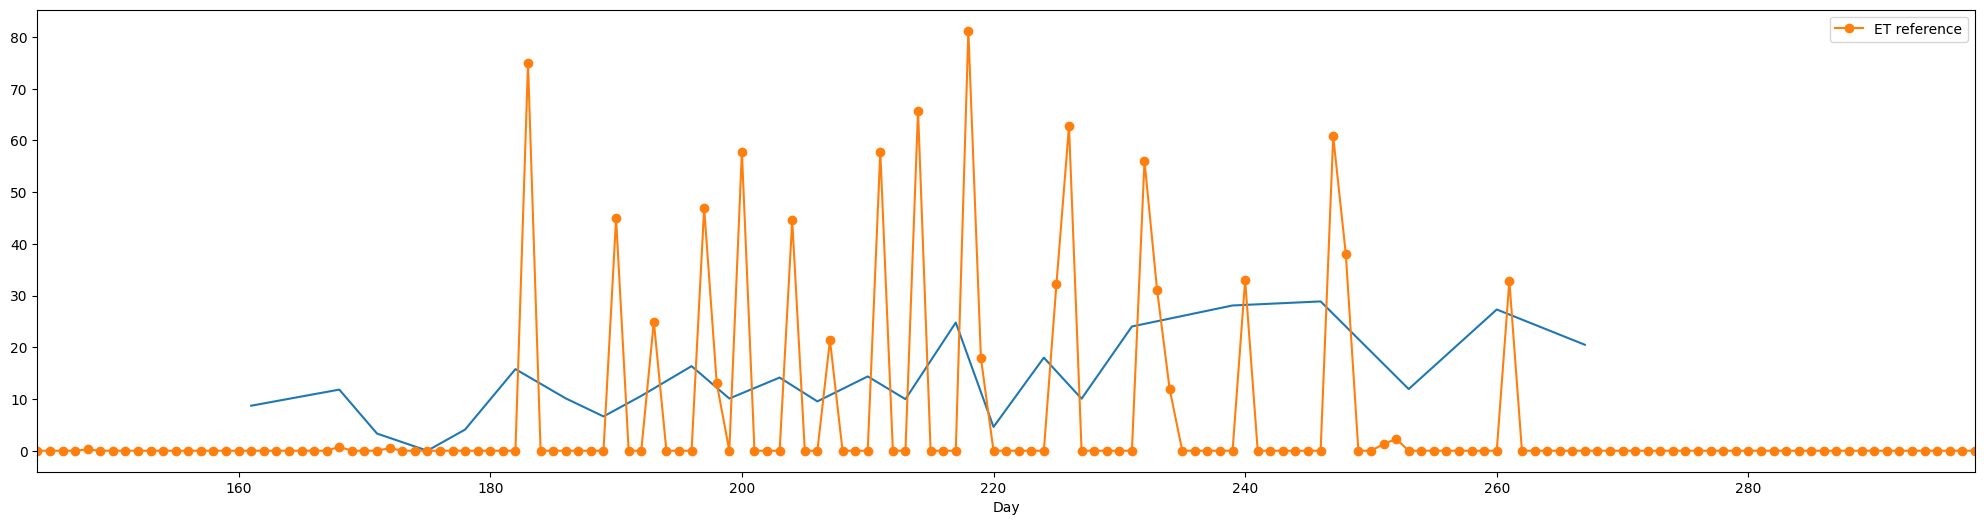

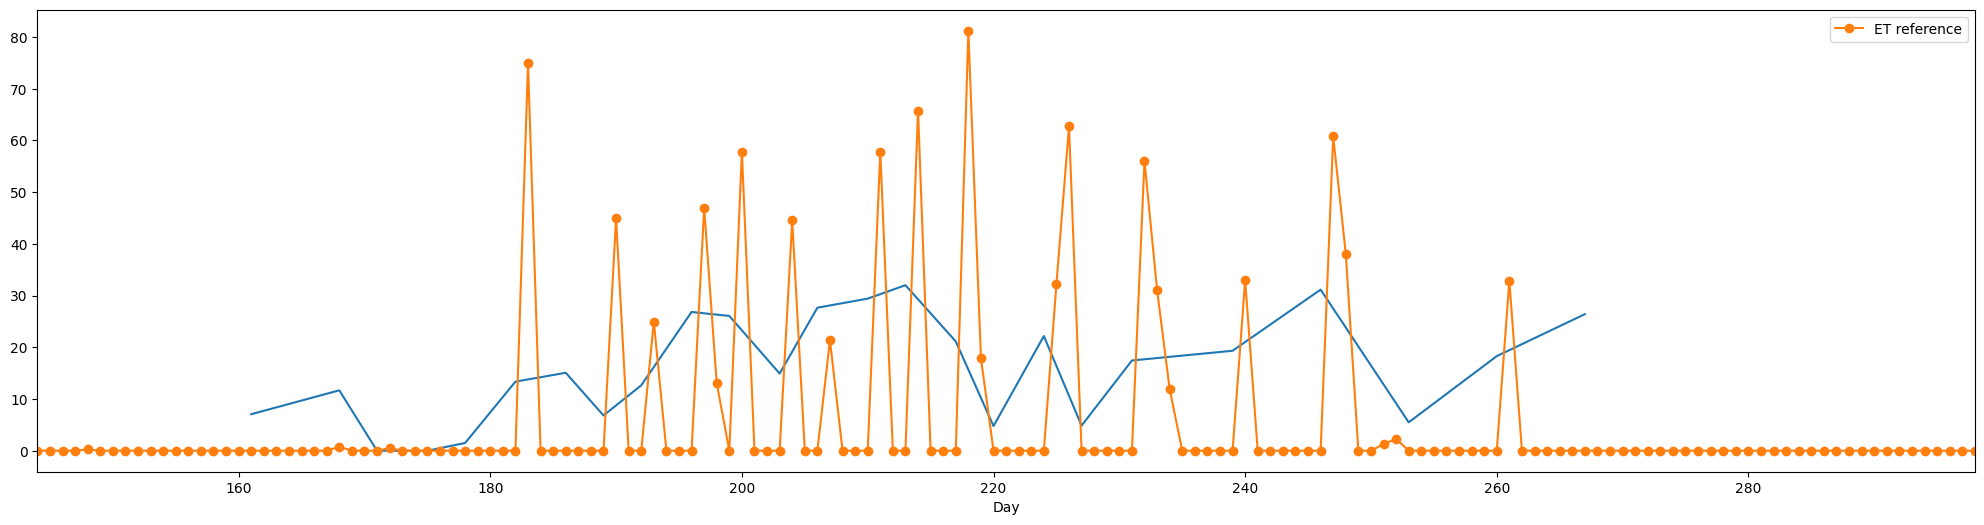

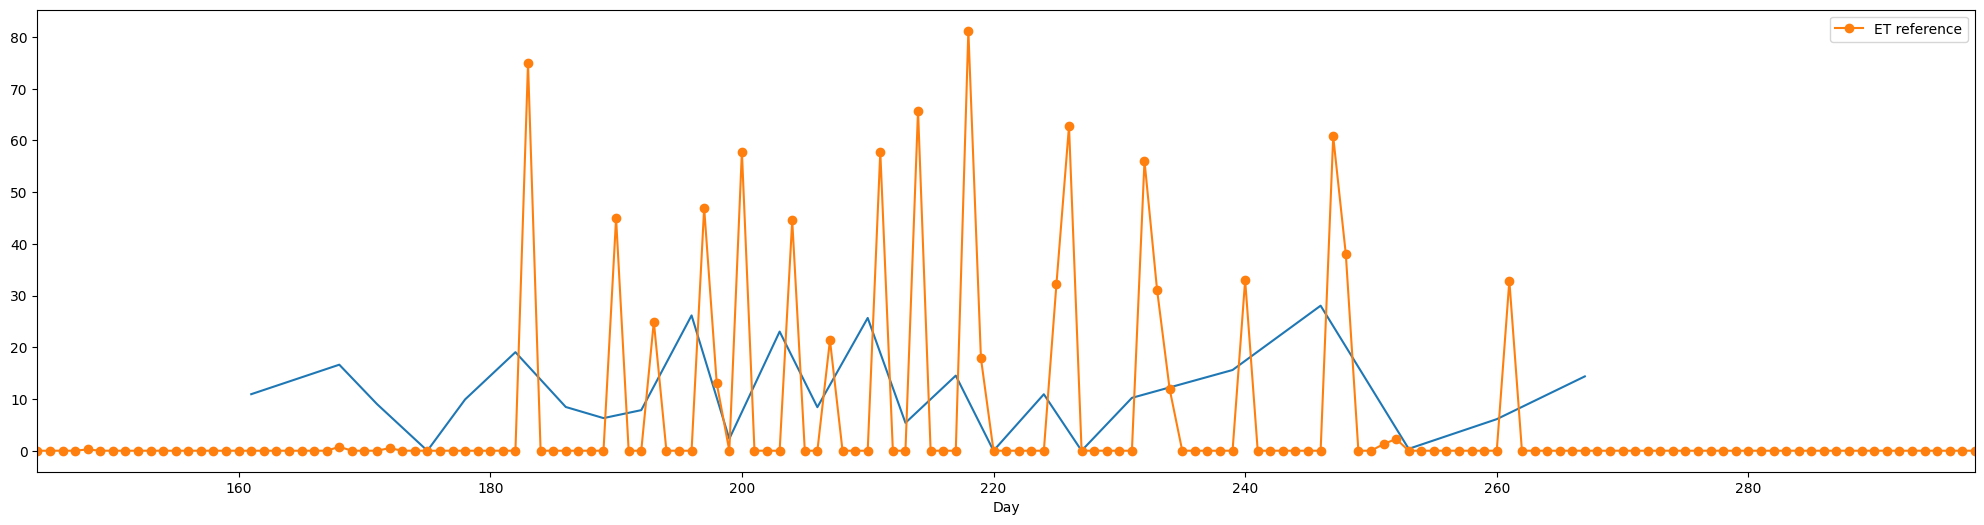

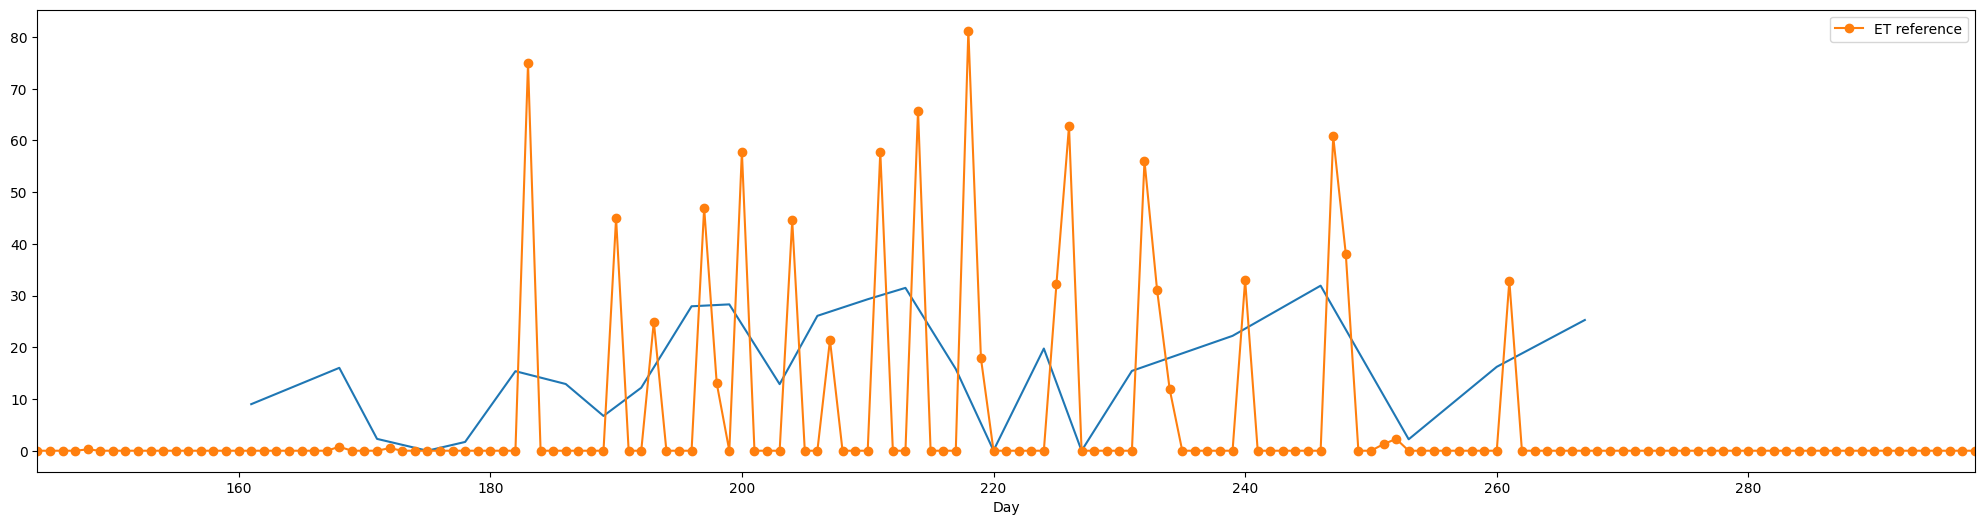

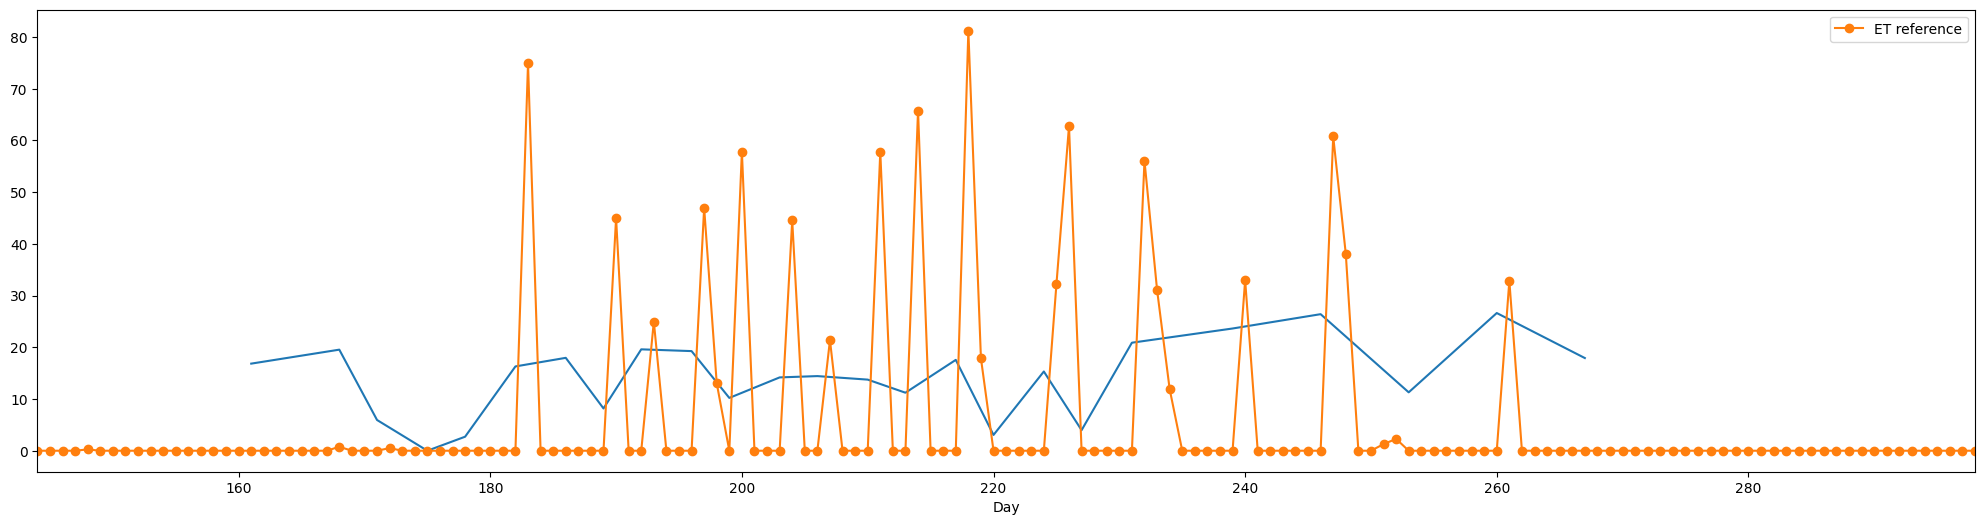

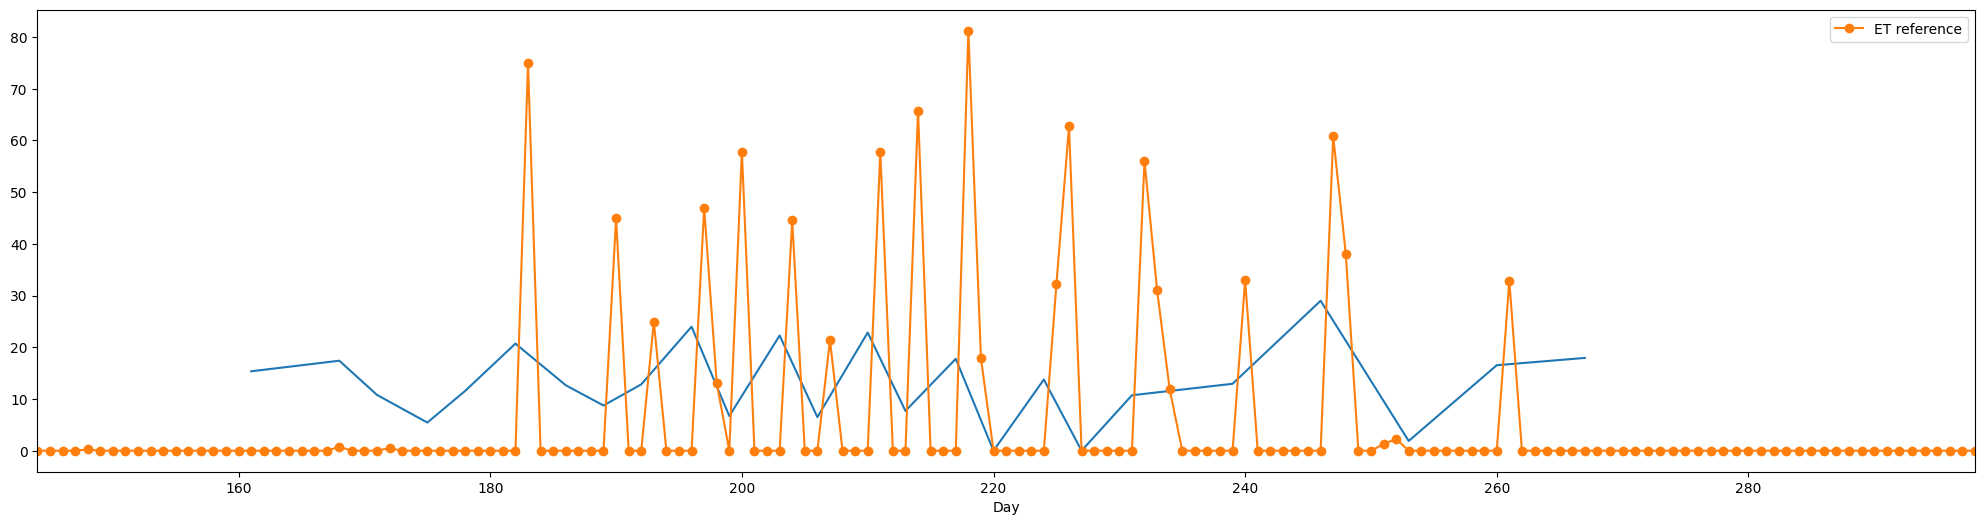

In [6]:
def load(file_name, sheet):
    return read_excel(file_name, sheet_name=sheet)

def load_file_thingy(file_name):
    #### Loading the information
    st = load(file_name, 'sites')
    idx = load(file_name, 'index')
    gs = load(file_name, 'growth stage')
    wx = load(file_name, 'weather')
    ir = load(file_name, 'irrigation')
    swd = load(file_name, 'soil water deficit')
    return st, idx, wx, ir, swd

def thing():
    path = ".././static/data.xlsx"
    st, idx, wx, ir, swd = load_file_thingy(path)
    site_name = st['site']
    

    
    pd={}

    for index, row in wx.iterrows():
    
        p = row["pp"]
        day = row["day"]
       
        pd[day] = p

    for day in range(min(pd.keys()), max(pd.keys())+1):
        if day not in pd.keys():
            pd[day] = 0

    for index, row in ir.iterrows():
        ir = row["Igross"]
        day = row["DOY"]

        pd[day] = pd[day] + ir
    
    swdplots = {}

    # for index, row in swd.iterrows():
    #     total = row["SWD_30"]+row["SWD_60"]+row["SWD_90"]+row["SWD_120"]+row["SWD_150"]+row["SWD_200"]
    #     day = row["DOY"]
    #     plot = str(row["plot"])

    for index, row in swd.iterrows():
        total = row["SWD_15"] + row["SWD_30"] + row["SWD_60"] + row["SWD_90"] + row["SWD_120"] + row["SWD_150"] + row["SWD_200"]
        if total < 0:
            total = 0
        swdplots.setdefault(row["plot"], {})[row["DOY"]] = total
    

    for plot in swdplots.keys():
        plt.figure(figsize=(25, 6))  # Width of 12 inches and height of 6 inches
        plt.plot(swdplots[plot].keys(), swdplots[plot].values())
        plt.plot(pd.keys(), pd.values(), marker='o', label="ET reference")
        plt.xlabel('Day')
        plt.xlim(min(swdplots[plot].keys()), max(swdplots[plot].keys()))
        plt.legend()
        plt.show()





thing()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

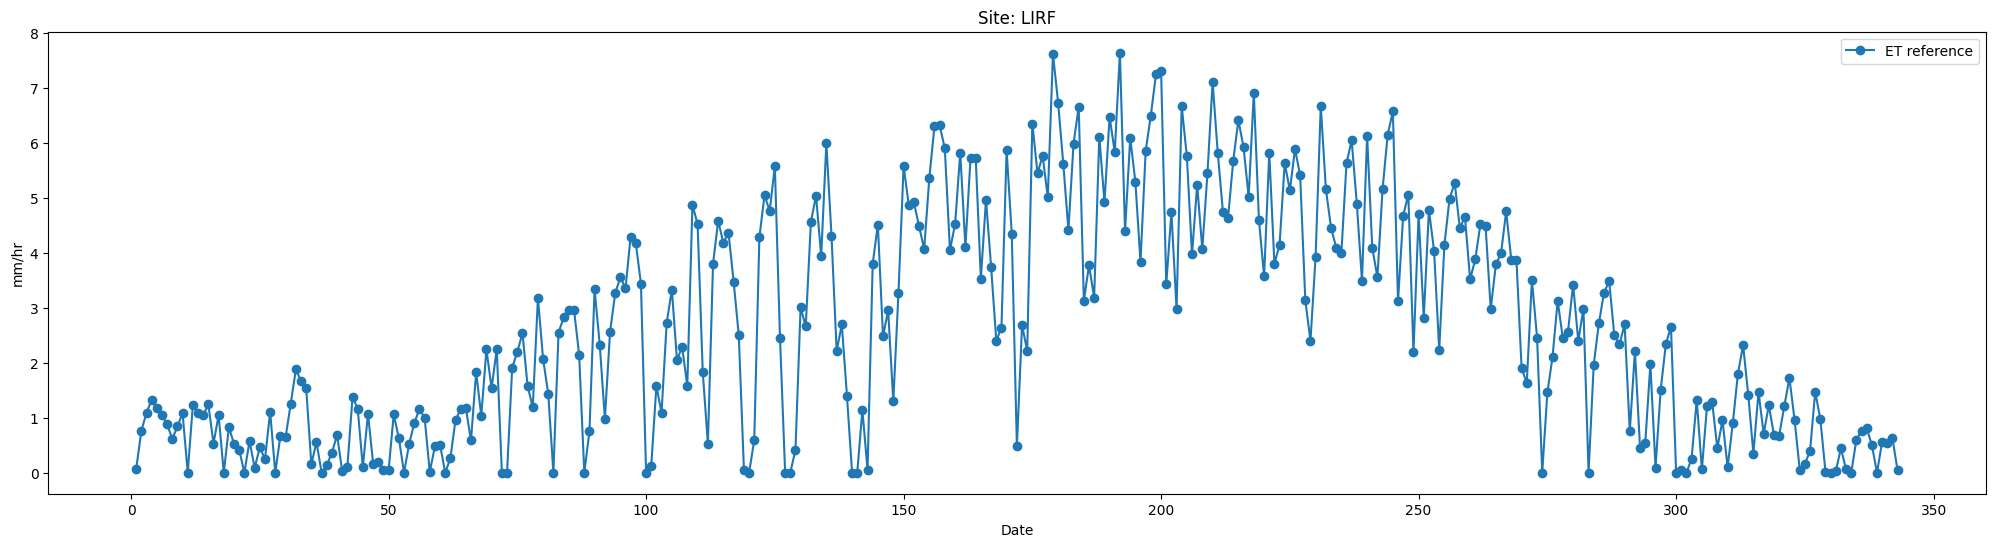

In [38]:
def thing():
    path = ".././static/data.xlsx"
    st, wx, idx = load_file(path)
    site_name = st['site']
    elevation = st["elev"]
    # equation is from https://edis.ifas.ufl.edu/publication/AE459 its not very readable here
    def theEquation(Ta, Rh, u2, Rs, elevation):
        A = (4098*(0.6108*(2.7183**((17.27*Ta)/(Ta+237.3))))) / ((Ta+273.3)**2)
        y = 0.000665*101.3*(((293-0.0065*elevation)/(293))**5.26)
        es = 0.6108*(2.7183**((17.27*Ta)/(Ta+237.3)))
        ea = es + Rh
        G = 0

        output = (0.408*A*(Rs-G) + y*((900/24)/(Ta+273))*u2*(es-ea)) / (A + y*(1+0.34*u2))
        output = np.where(output < 0, 0, output)
        return output
    
    result = []
    date = []
    the_dictionary={}

    for index, row in wx.iterrows():
        Ta = row["Ta"]
        Rh = row["RH"]
        u2 = row["u2"]
        Rs = row["Rs"]

        year = row["year"]
        day = row["day"]
        hour = row["hour"]
            
        output = theEquation(Ta,Rh,u2,Rs,elevation)

        if day in the_dictionary:
            the_dictionary[day] += output
        else:
            the_dictionary[day] = output


        year_start = datetime(year,1,1)
        dt = year_start + timedelta(days=day - 1, hours=hour)
        dt.replace(minute=0, second=0)
        
        date.append(dt)
        result.append(output)

    print(the_dictionary.keys())

    plt.figure(figsize=(25, 6))  # Width of 12 inches and height of 6 inches
    # plt.plot(wx.index, result, marker='o', label="ET reference")
    # plt.plot(date, result, marker='o', label="ET reference")
    plt.plot(the_dictionary.keys(), the_dictionary.values(), marker='o', label="ET reference")


    plt.title(f"Site: {site_name.iloc[0]}")
    plt.xlabel('Date')
    plt.ylabel("mm/hr")
    plt.legend()
    plt.savefig(f".././static/ETreference.png")

    plt.show()
    # print(st["elev"].loc[0])
    # print(date)
    for i in range(len(result)):
        if((result[i] < 0).all()):
            print(f"{date[i]}")

    # print(date)
thing()

In [5]:
def theEquation(Ta, Rh, u2, Rs, elevation):
        A = (4098*(0.6108*(2.7183**((17.27*Ta)/(Ta+237.3))))) / ((Ta+273.3)**2)
        y = 0.000665*101.3*(((293-0.0065*elevation)/(293))**5.26)
        es = 0.6108*(2.7183**((17.27*Ta)/(Ta+237.3)))
        ea = es + Rh
        G = 0

        output = (0.408*A*(Rs-G) + y*((900/24)/(Ta+273))*u2*(es-ea)) / (A + y*(1+0.34*u2))
        output = np.where(output < 0, 0, output)
        return output
def get_ETr(st, wx):
    elevation = st["elev"]
    result = []
    date = []
    the_dictionary={}

    for index, row in wx.iterrows():
        Ta = row["Ta"]
        Rh = row["RH"]
        u2 = row["u2"]
        Rs = row["Rs"]
        day = row["day"]
            
        output = theEquation(Ta,Rh,u2,Rs,elevation)

        if day in the_dictionary:
            the_dictionary[day] += output
        else:
            the_dictionary[day] = output
    return the_dictionary

In [6]:
    path = ".././static/data.xlsx"
    st, wx, idx = load_file(path)
    ETr_dictionary = get_ETr(st, wx)
    print(ETr_dictionary.values())

dict_values([array([0.07583178]), array([0.76288179]), array([1.09458251]), array([1.32775406]), array([1.18285468]), array([1.04582259]), array([0.88165823]), array([0.61286373]), array([0.8416974]), array([1.08525809]), array([0.]), array([1.23956614]), array([1.09334946]), array([1.04662773]), array([1.24675803]), array([0.53123729]), array([1.04752508]), array([0.]), array([0.83002629]), array([0.52018873]), array([0.41693772]), array([0.]), array([0.57529833]), array([0.08916259]), array([0.46554249]), array([0.24363325]), array([1.10762559]), array([0.00124148]), array([0.67274336]), array([0.64475937]), array([1.25618681]), array([1.88198646]), array([1.66570721]), array([1.54265872]), array([0.15372789]), array([0.55700307]), array([0.]), array([0.13441565]), array([0.36518614]), array([0.68626389]), array([0.02741144]), array([0.10663357]), array([1.3794571]), array([1.16837526]), array([0.10223186]), array([1.07473552]), array([0.16624962]), array([0.20378415]), array([0.0564

142


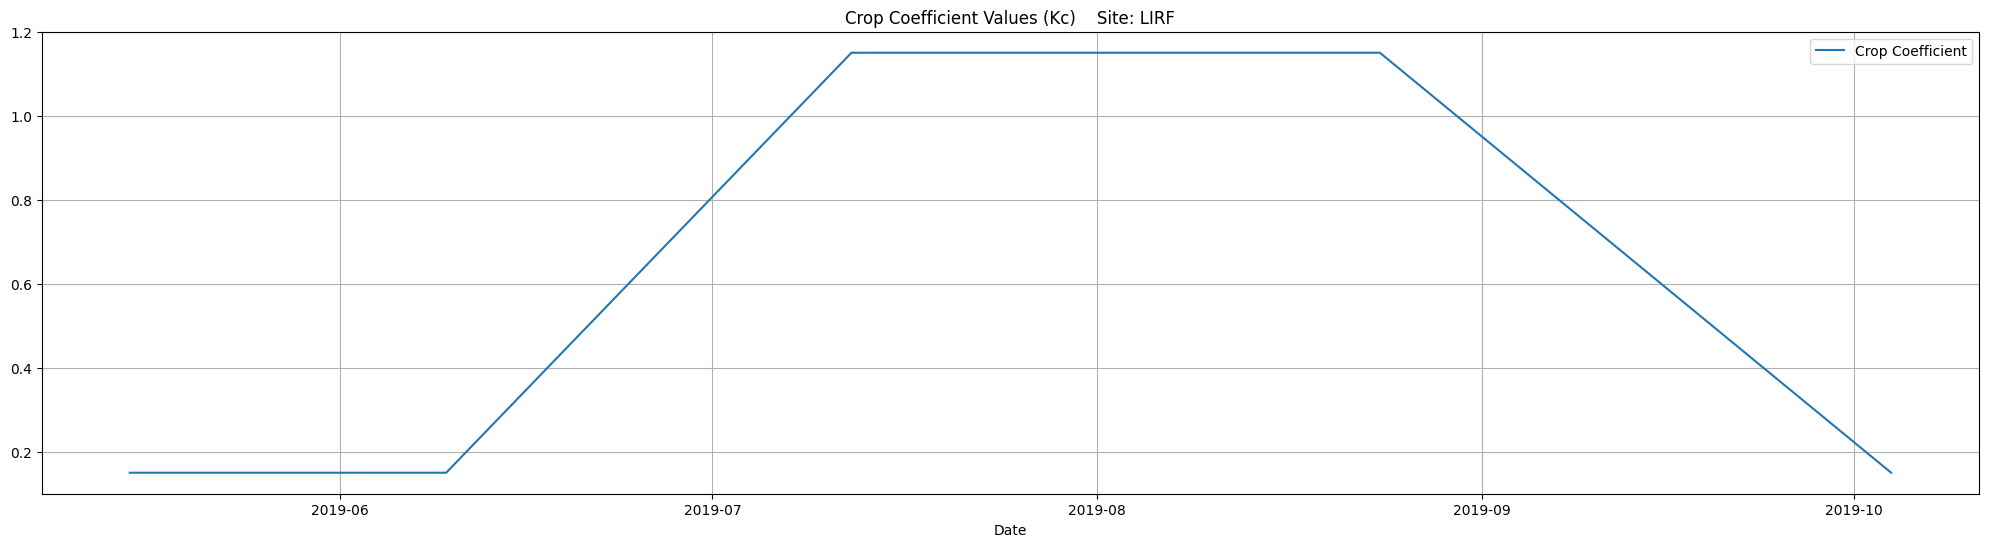

3408


In [12]:
def load_filegs(file_name):
    #### Loading the information
    return load(file_name, 'canopy temperature'), load(file_name, 'sites')

def thing():
    
    path = ".././static/data.xlsx"
    tc, st = load_filegs(path)
    
    site_name = st['site']
    year = tc["year"].iloc[0]

    # start_day = int(tc.iloc[0]["DOY"])
    # end_day = int(tc.iloc[-1]["DOY"])
    start_day = 135
    end_day = 277
    length = end_day - start_day

    print(length)

    # Values from:
    # https://asabe.org/portals/0/apubs/books/ism/irrigationsystemsmanagement.pdf
    initial = 0.15
    top = 1.15
    end = 0.15


    # stable
    fs1 = 0.18 * length
    # increasing
    fs2 = 0.41 * length
    # stable
    fs3 = 0.71 * length
    # decreasing

    fs1 = float(int(fs1*24))/24 + start_day
    fs2 = float(int(fs2*24))/24 + start_day
    fs3 = float(int(fs3*24))/24 + start_day

    kc = []
    date = []

    for day in range(length):
        day = day + start_day
        for hour in range(24):
            hour = hour + 1
            time = day + (hour/24)

            if time <= fs1:
                kc.append(initial)
            elif time <= fs2:
                span = fs2 - fs1
                current = time - fs1
                percentage = current / span
                kc.append((top - initial) * percentage + initial)
            elif time <= fs3:
                kc.append(top)
            else:
                # equation\ double check this
                span = end_day - fs3
                current = time - fs3
                percentage = current / span
                kc.append(top - ((top - end) * percentage))


            year_start = datetime(year,1,1)
            dt = year_start + timedelta(days=day - 1, hours=hour)
            dt.replace(minute=0, second=0)
            date.append(dt)
            

    plt.figure(figsize=(25, 6))  # Width of 12 inches and height of 6 inches
    # plt.plot(wx.index, result, marker='o', label="ET reference")
    plt.plot(date, kc, label="Crop Coefficient")

    plt.title(f"Crop Coefficient Values (Kc)    Site: {site_name.iloc[0]}")
    plt.xlabel('Date')
    plt.legend()
    # plt.savefig(f".././static/ETreference.png")
    plt.grid()
    plt.show()
    print(len(date))


thing()

In [8]:
def get_Kc(start_day, end_day):
    length = end_day - start_day
    the_dictionary = {}

    # Values from:
    # https://asabe.org/portals/0/apubs/books/ism/irrigationsystemsmanagement.pdf
    initial = 0.15
    top = 1.15
    end = 0.15

    fs1 = 0.18 * length
    fs2 = 0.41 * length
    fs3 = 0.71 * length

    fs1 = float(int(fs1*24))/24 + start_day
    fs2 = float(int(fs2*24))/24 + start_day
    fs3 = float(int(fs3*24))/24 + start_day

    for day in range(length):

        day = day + start_day

        if day <= fs1:
            output = initial
        elif day <= fs2:
            span = fs2 - fs1
            current = day - fs1
            percentage = current / span
            output = (top - initial) * percentage + initial
        elif day <= fs3:
            output = top
        else:
            span = end_day - fs3
            current = day - fs3
            percentage = current / span
            output = top - ((top - end) * percentage)

        if day in the_dictionary:
            the_dictionary[day] += output
        else:
            the_dictionary[day] = output
    
    return the_dictionary
           

In [9]:
dictionary = get_Kc(135, 277)
print(dictionary.keys())

dict_keys([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276])


!!!!!!!!!! START !!!!!!!!!!


/tmp/ipykernel_28098/829991151.py:58: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  cc_tmp = cc_tmp.set_index('DOY').reindex(doy).sort_index().interpolate() \
/tmp/ipykernel_28098/829991151.py:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theoretical_result.append(float(ETr_dictionary[now] * Kc_dictionary[now] * cwsi_t2_dictionary[now]))
/tmp/ipykernel_28098/829991151.py:238: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  emperical_result.append(float(ETr_dictionary[now] * Kc_dictionary[now] * cwsi_e_dictionary

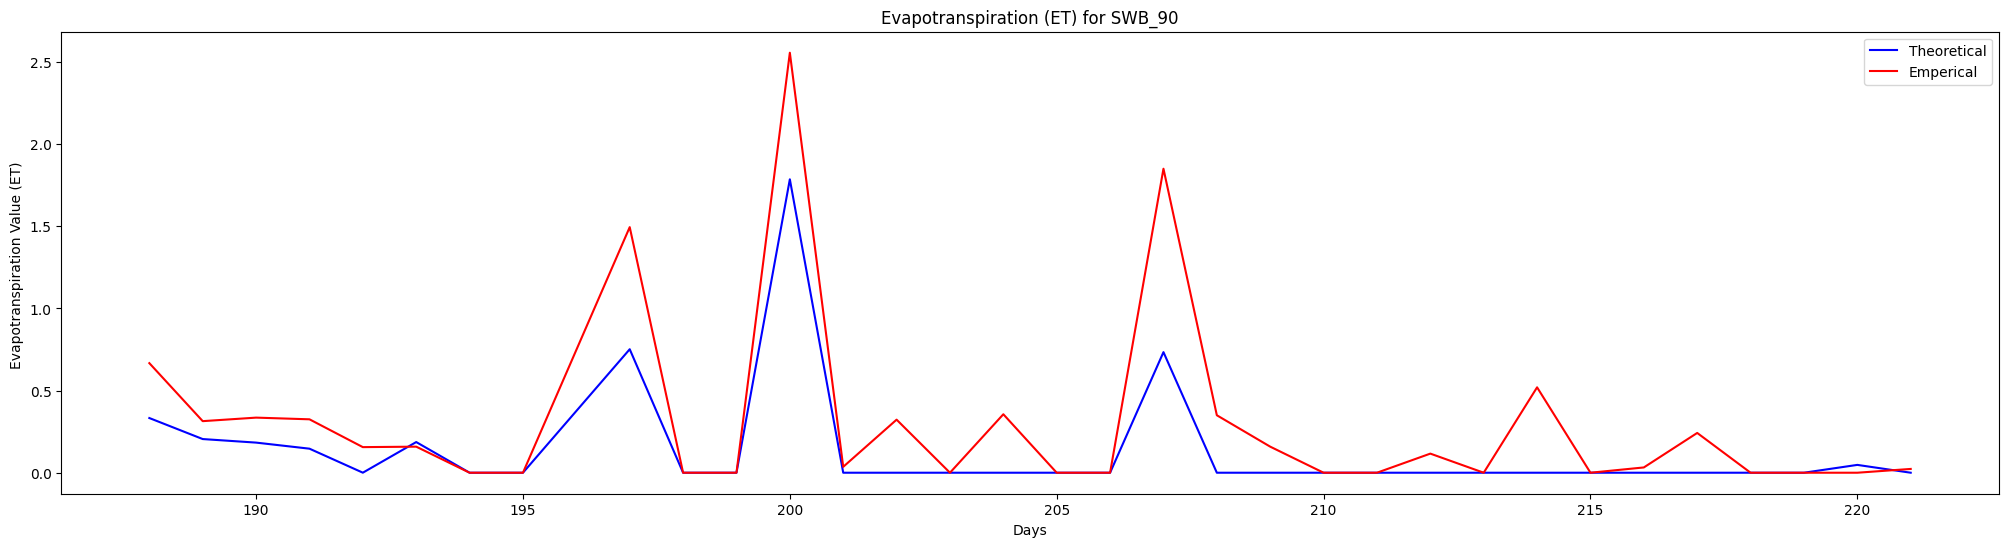

In [10]:
## Import functions
import ETrprocess as ETr
import Kc_process as Kc

# from ETr import get_ETr
# from Kc import get_Kc

import asce as asce
import cwsi as cwsi
import irls as irls
import numpy as np
from pandas import read_excel, concat, DataFrame, Index, MultiIndex, date_range
from numpy import empty, full
import matplotlib.pyplot as plt


def load(file_name, sheet):
    return read_excel(file_name, sheet_name=sheet)

def load_filename(file_name):

    #### Loading the information
    st = load(file_name, 'sites')
    wx = load(file_name, 'weather')
    idx = load(file_name, 'index')

    ### canopy temperature
    tc = load(file_name, 'canopy temperature') \
            .merge(idx, on='plot', how='right') \
            .groupby(['DOY', 'hour', 'treatment'])['Tc'] \
            .mean() \
            .reset_index()
            

    cc = load(file_name, 'canopy cover') \
            .merge(idx, on='plot', how='right') \
            .groupby(['DOY', 'treatment'])['cc'] \
            .mean() \
            .reset_index()

    ### SAP: provides a measurement of the transpiration of the plant
    sa = load(file_name, 'sap flow') \
            .merge(idx, on='plot', how='right') \
            .groupby(['treatment', 'DOY', 'hour'])['sap'] \
            .mean() \
            .reset_index() \
            .rename(columns={'sap': 'Sa'})

    return tc, cc, wx, st, idx

def treatment_selection(tc, cc, wx, treatment = 'SWB_90'):
    
    wx['DOY'] = wx['day']               ### Main file Sc computation has problems without DOY in wx, Linh changed
    
    ### Filter the the calculation in the treatment
    cc_tmp = cc[cc['treatment'] == treatment]
    doy = Index(range(cc_tmp['DOY'].min(), cc_tmp['DOY'].max() + 1), name='DOY')
    cc_tmp = cc_tmp.set_index('DOY').reindex(doy).sort_index().interpolate() \
            .reset_index()
    tc_tmp = tc[tc['treatment'] == treatment]
    tmp = []
    for _, df in tc_tmp.groupby('DOY'):
            if len(df) == 24:
                tmp.append(df)
                
    tc_tmp = concat(tmp).sort_values(['DOY', 'hour'])
    days = set(cc_tmp['DOY']).intersection(tc_tmp['DOY']).intersection(wx['DOY'])
    cc_tmp = cc_tmp[cc_tmp['DOY'].isin(days)]
    tc_tmp = tc_tmp[tc_tmp['DOY'].isin(days)]
    wx_tmp = wx[wx['DOY'].isin(days)]

    ### There is a mask applied as a filter to dataframe wx
    df = tc_tmp.merge(wx_tmp, on=['DOY', 'hour'])
    
    return df


def plots_the_retrieval(idx, tc, cc, wx, st, day_start, day_end, treatment_select, h0, h_end, hour_select, plot_cwsi = True, plot_ab = True):
    df = treatment_selection(tc, cc, wx, treatment_select)

    # num_days = len(df['DOY'].unique())
    # num_hours_points = len(range(h0, h_end))
    # n = int(num_days * num_hours_points)
    
    steps = day_end - day_start + 1
    days = np.linspace(day_start, day_end, steps)
    days = [int(item) for item in days]
    h_end = h_end + 1     ### Due to the range function
    

    # print(days)

    ### Data for the date 196 not available
    if 196 in days:
        days.remove(196)
    else:
        pass
    
    num_days = len(days)
    num_hours_points = len(range(h0, h_end))
    n = int(num_days * num_hours_points)
    
    #### Initialize the values: see Cullen's updated function
    DELTA = empty(n)
    Rnc = empty(n)
    VPD = empty(n)
    # omega = empty(n)
    rho = empty(n)
    
    ### Same thing: fixed for all days
    z = st['elev'][0]
    st['P'] = P = asce.P(st['elev'][0])         ### atmospheric pressure (kPa)
    st['Lm'] = Lm = asce.Lm(st['lon'][0])     ### See function Lm: longitude of measurement site (positive degrees west of Greenwich England)
    st['gamma'] = gamma = asce.gamma(P)         #### psychrometric constant (kPa*C^-1)
    st['phi'] = phi = asce.phi(st['lat'][0])    ### latitude of measurement site (rad)
    Lz = st['Lz'][0]
    fcd = 0.055 # initialize fcd for cloudless night
    
    ## Filter the Tc and Ta
    Tc_range = []
    Ta_range = []
    
    for i, DOY in enumerate(days):
        Sc = asce.Sc(DOY)
        delta = asce.delta(DOY)
        omegas = asce.omegas(delta, phi)
        dr = asce.dr(DOY)
        df_oneday = df[df['DOY']== DOY]
        Rs = df_oneday['Rs'].values
        Ta = df_oneday['Ta'].values
        RH = df_oneday['RH'].values
        Tc = df_oneday['Tc'].values
        for j, h in enumerate(range(h0, h_end)):
            Rsh, Tah, Tch = Rs[h], Ta[h], Tc[h] # store for multiple uses
            omega = asce.omega(Lm, Lz, Sc, h, 60, 1)            # Cullen applied condition on omega but not here since the time constraint in Linh's
            omega2 = asce.omega2(omega, omegas, 1)
            omega1 = asce.omega1(omega, omega2, omegas, 1)
            Ra = asce.Ra(dr, delta, omega1, omega2, phi)
            Rso = asce.Rso(Ra, z)
            beta = asce.beta(delta, omega, phi)
            fcd = asce.fcd(Rsh, Rso, beta, fcd)
            es = asce.es(Ta[h])
            ea = asce.ea(RH[h], es)
            Rnl = asce.Rnl(Tah, ea, fcd)
            Rns = asce.Rns(Rsh)
            Rn = asce.Rn(Rnl, Rns)
            DELTA[i*num_hours_points + j] = asce.DELTA(Tah)
            rho[i*num_hours_points + j] = cwsi.rho(P, Tah)
            Rnc[i*num_hours_points + j] = cwsi.Rnc(Rn)
            VPD[i*num_hours_points + j] = es - ea
            
            Tc_range.append(Tch)
            Ta_range.append(Tah)
            
    Tc_range = np.array(Tc_range)
    Ta_range = np.array(Ta_range)
    
    dif = Tc_range - Ta_range
    DELTA_bar = DELTA.mean()
    Rnc_bar = Rnc.mean()
    rho_bar = rho.mean()
    
    # robust (iteratively reweighted least squares, Tukey edition) regression
    X = irls.design(VPD, 1) # first degree polynomial design matrix
    (a, b), _ = irls.irls(X, dif) # regression coefficeints (ignore weights)
    ra_bar = cwsi.ra(DELTA_bar, Rnc_bar, a, b, rho_bar) # aerodynamic resistance
    rc_bar = cwsi.rc(DELTA_bar, b, gamma, ra_bar) # canopy resistance  
    
    ############################################
    ############################################ After retrieving a, b, ra_bar, rc_bar
    cwsi_e = []
    cwsi_t2 = []

    cwsi_e_dictionary = {}
    cwsi_t2_dictionary = {}

    del DELTA
    del rho
    
    for i, DOY in enumerate(days):
        Sc = asce.Sc(DOY)
        delta = asce.delta(DOY)
        omegas = asce.omegas(delta, phi)
        dr = asce.dr(DOY)
        df_oneday = df[df['DOY']== DOY]
        Rs = df_oneday['Rs'].values
        Ta = df_oneday['Ta'].values
        RH = df_oneday['RH'].values
        Tc = df_oneday['Tc'].values
        for j, h in enumerate(range(h0, h_end)):
            Rsh, Tah, Tch = Rs[h], Ta[h], Tc[h] # store for multiple uses
            omega = asce.omega(Lm, Lz, Sc, h, 60, 1)            # Cullen applied condition on omega but not here since the time constraint in Linh's
            omega2 = asce.omega2(omega, omegas, 1)
            omega1 = asce.omega1(omega, omega2, omegas, 1)
            Ra = asce.Ra(dr, delta, omega1, omega2, phi)
            Rso = asce.Rso(Ra, z)
            beta = asce.beta(delta, omega, phi)
            fcd = asce.fcd(Rsh, Rso, beta, fcd)
            es = asce.es(Tah)
            ea = asce.ea(RH[h], es)
            Rnl = asce.Rnl(Tah, ea, fcd)
            Rns = asce.Rns(Rsh)
            Rn = asce.Rn(Rnl, Rns)
            DELTA = asce.DELTA(Tah)   ## diffrent from DELTA in previous loop
            rho = cwsi.rho(P, Tah)
            Rnc = cwsi.Rnc(Rn)
            ul = cwsi.ul(Rnc, ra_bar, rho)
            ll = cwsi.ll(DELTA, ea, es, gamma, ra_bar, rc_bar, ul)
            if h == hour_select:  
                cwsi_t2.append(cwsi.cwsi(Tah, Tch, ll, ul))
                cwsi_t2_dictionary[DOY] = cwsi.cwsi(Tah, Tch, ll, ul)

            ##### The part of emperical method
            vpd = es - ea
            vpg = es - asce.es(Tah + a)
            ul_e = a + b * vpg
            ll_e = a + b * vpd
            if h == hour_select:
                cwsi_e.append(cwsi.cwsi(Tah, Tch, ll_e, ul_e))
                cwsi_e_dictionary[DOY] = cwsi.cwsi(Tah, Tch, ll_e, ul_e)
                
    ETr_dictionary = ETr.get_ETr(st, wx)
    Kc_dictionary = Kc.get_Kc(day_start, day_end)
    
    theoretical_result = []
    theoretical_date = []

    emperical_result = []
    emperical_date = []

    now = day_start
    while (now <= day_end):
        if (now in ETr_dictionary and now in Kc_dictionary and now in cwsi_t2_dictionary):
            theoretical_result.append(float(ETr_dictionary[now] * Kc_dictionary[now] * cwsi_t2_dictionary[now]))
            theoretical_date.append(now)

        if (now in ETr_dictionary and now in Kc_dictionary and now in cwsi_t2_dictionary):
            emperical_result.append(float(ETr_dictionary[now] * Kc_dictionary[now] * cwsi_e_dictionary[now]))
            emperical_date.append(now)
        now=now+1

    #### Plot the results
    plt.figure(figsize=(25, 6))

    # plt.figure()
    plt.plot(theoretical_date, theoretical_result, 'blue', label = "Theoretical")
    plt.plot(emperical_date, emperical_result, 'r', label = "Emperical")
    plt.xlabel('Days')
    plt.ylabel('Evapotranspiration Value (ET) ')
    plt.title("Evapotranspiration (ET) for " + treatment_select)
    plt.legend()
    # plt.savefig("./static/merged_result.png")
    plt.show()
    # print(emperical_result)
    # print(theoretical_result)

    

def plot_the_buttons(file_name, day_start, day_end, treatment, start_hour, end_hour, select_hour): 
    print("!!!!!!!!!! START !!!!!!!!!!")

    tc, cc, wx, st, idx = load_filename(file_name)
    plots_the_retrieval(idx, tc, cc, wx, st, day_start, day_end, treatment, start_hour -1, end_hour, select_hour-1)

plot_the_buttons(".././static/data.xlsx", 188, 222, "SWB_90", 10, 15, 12)

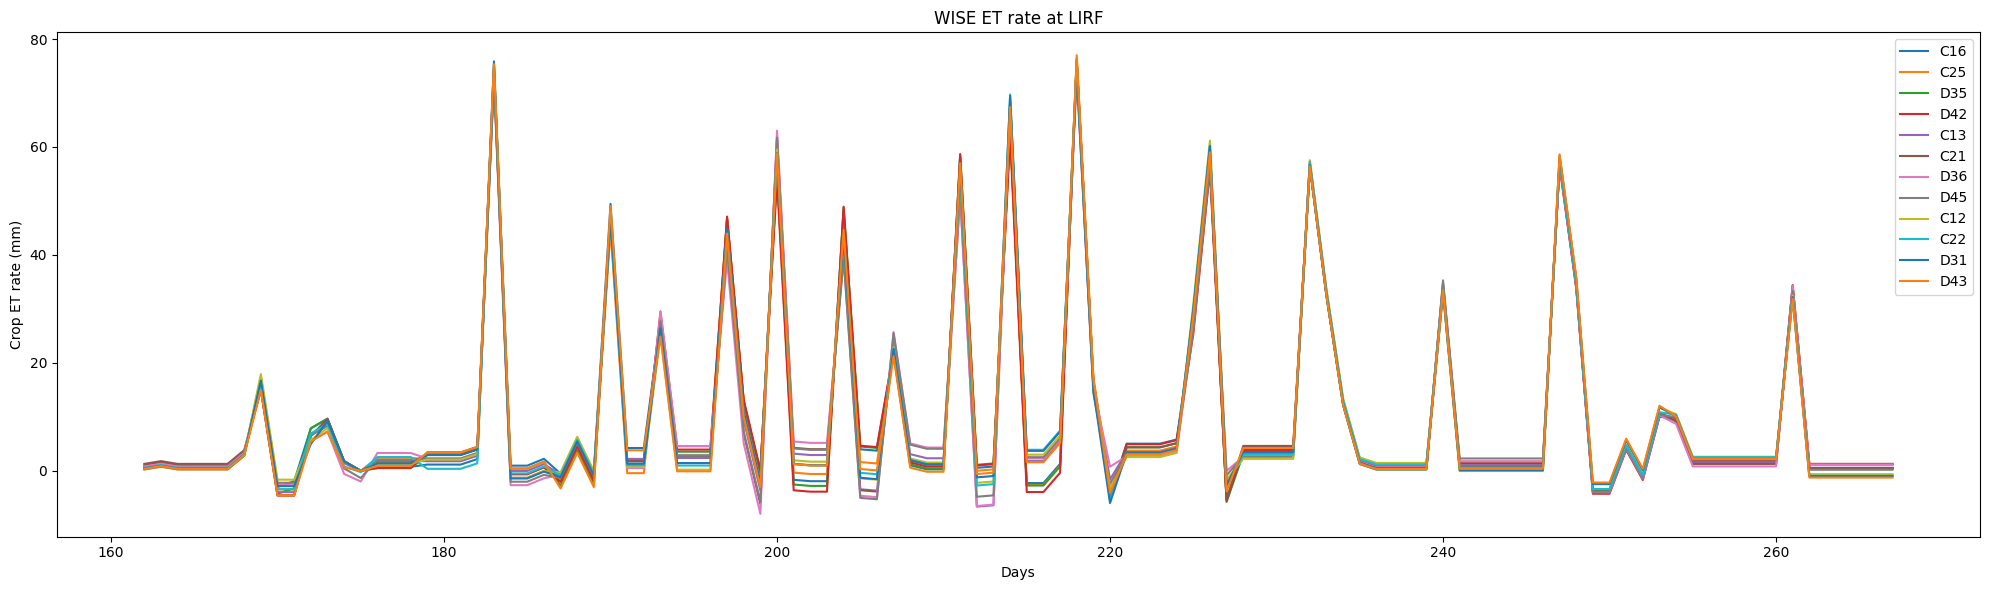

In [8]:
def load_the_file(file_name):

    #### Loading the information
    st = load(file_name, 'sites')
    wx = load(file_name, 'weather')
    idx = load(file_name, 'index')

    ## irrigation
    ir = load(file_name, 'irrigation')
            
    ### soil water deficit
    swd = load(file_name, 'soil water deficit') \
            .merge(idx, on='plot', how='right')
  
    return idx, st, swd, wx, ir


def processfile():
    path = ".././static/data.xlsx"

    df = read_excel(path)

    idx, st, swd, wx, ir = load_the_file(path)

    swd_dictionary = {}

    for index, row in swd.iterrows():
        total = row["SWD_15"] + row["SWD_30"] + row["SWD_60"] + row["SWD_90"] + row["SWD_120"] + row["SWD_150"] + row["SWD_200"]
        swd_dictionary.setdefault(row["plot"], {})[row["DOY"]] = total

    irr_dictionary = {}

    for index, row in ir.iterrows():
        if row["DOY"] in irr_dictionary:
            irr_dictionary[row["DOY"]] += row["Igross"]
        else:
            irr_dictionary[row["DOY"]] = row["Igross"]

    pre_dictionary = {}

    for index, row in wx.iterrows():
        if row["day"] in pre_dictionary:
            pre_dictionary[row["day"]] += row["pp"]
        else:
            pre_dictionary[row["day"]] = row["pp"]
    

    all_plots = {}

    for plot in swd_dictionary.keys():

        dictionary = swd_dictionary[plot]

        days_available = list(dictionary.keys())
        new_thing = {}

        for day in range(min(dictionary.keys()),max(dictionary.keys()) + 1):
            if day not in pre_dictionary.keys():
                pre_dictionary[day] = 0
            if day not in irr_dictionary.keys():
                irr_dictionary[day] = 0

            if day not in dictionary.keys():

                start = 0
                end = 0

                found = False
                for i, available in enumerate(days_available):
                    if not found and day > available and day < days_available[i+1]:
                        start = available
                        end = days_available[i+1]

                        found = True

                output = dictionary[start] + ((dictionary[end]-dictionary[start])/(end-start)) * (day-start)
                dictionary[day] = output

            if day != days_available[0]:
                if dictionary[day] < 0:
                    dictionary[day] = 0

                final = dictionary[day] - dictionary[day-1] + pre_dictionary[day] + irr_dictionary[day]
                new_thing[day] = final
                
        all_plots[plot] = new_thing

        # plt.plot(new_thing.keys(), new_thing.values(), 'orange', label="ET")
        # plt.title(f"Plot: {plot}")
        # plt.legend()
        # plt.show()


    plt.figure(figsize=(20, 6))
    for plot in all_plots.keys():
        plt.plot(all_plots[plot].keys(), all_plots[plot].values(), label=plot)

    plt.xlabel('Days')
    plt.ylabel('Crop ET rate (mm)')
    plt.title(f"WISE ET rate at {st["site"].iloc[0]}")
    plt.tight_layout()
    plt.legend()
    plt.show()
processfile()